# Streetcar Delay Prediction

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - 2018 to predict future delays and come up with recommendations for avoiding delays.

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [43]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [44]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [45]:
valid_directions = ['E/B','W/B','N/B','S/B']

In [46]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [47]:
! pwd

/notebooks/manning/notebooks


# Load and Save Data
- parse list of XLS files 
- load XLS files, tab by tab, into dataframe
- pickle dataframe for future runs

In [48]:
# variables to control function of this notebook
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = True
# control whether to save dataframe with transformed data
save_transformed_dataframe = True

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime
import os


In [50]:
!pwd

/notebooks/manning/notebooks


In [51]:
# get the directory for that this notebook is in
rawpath = os.getcwd()
print("raw path is",rawpath)

raw path is /notebooks/manning/notebooks


In [52]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

path is /notebooks/manning/data/


In [53]:
# pickled_dataframe = '20142018_df.pkl'
pickled_input_dataframe = '2014_2018.pkl'
pickled_output_dataframe = '2014_2018_df.pkl'
# path,picklename,firstfile, firstsheet
firstfile = 'Streetcar_2018_aug_nov.xlsx'
firstsheet = 'Aug 2018'
newload = False


In [54]:
#path = os.getcwd()
def get_xls_list(path):
    # path = '../datasets/'
    files = os.listdir(path)
    files_xls = [f for f in files if f[-4:] == 'xlsx']
    print(files)
    print(files_xls)
    return(files_xls)


In [55]:
def load_xls(path, files_xls, firstfile, firstsheet, df):
    for f in files_xls:
        print("file name",f)
        xlsf = pd.ExcelFile(path+f)
        # iterate through sheets
        for sheet_name in xlsf.sheet_names:
            print("sheet_name",sheet_name)
            if (f != firstfile) or (sheet_name != firstsheet):
                print("sheet_name in loop",sheet_name)
                data = pd.read_excel(path+f,sheetname=sheet_name)    
                df = df.append(data)
    return (df)

In [60]:
def reloader(path,picklename):
    # get list of all xls files in the path
    files_xls = get_xls_list(path)
    print("list of xls",files_xls)
    # seed initial tab on initial xls file
    dfnew = pd.read_excel(path+files_xls[0])
    # get the list of sheets in the first file
    xlsf = pd.ExcelFile(path+files_xls[0])
    # load the remaining tabs from all the other xls
    # pass the first file (files_xls[0]) and the first tab in that file (xlsf[0]) explicitly
    dflatest = load_xls(path,files_xls,files_xls[0],xlsf.sheet_names[0], dfnew)
    # save dataframe to pickle
    dflatest.to_pickle(path+ picklename)
    # return dataframe loaded with all tabs of all xls files
    return(dflatest)
    

In [61]:
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [62]:
def fill_missing(dataset):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [63]:
# read in previously pickled dataframe containing data from s/s 2014 - 2018
if load_from_scratch:
    unpickled_df = reloader(path,pickled_input_dataframe)
    print("reloader done")
    #unpickled_df = pd.read_pickle(path+pickled_data_file)
else:
    unpickled_df = pd.read_pickle(path+pickled_input_dataframe)

['Streetcar 2015.xlsx', 'iriscaps.csv', 'Streetcar 2014.xlsx', 'Streetcar_2019.xlsx', 'iris.csv', 'Streetcar_2018.xlsx', 'iris_dataframe.pkl', 'Streetcar 2017.xlsx', 'Streetcar 2016.xlsx']
['Streetcar 2015.xlsx', 'Streetcar 2014.xlsx', 'Streetcar_2019.xlsx', 'Streetcar_2018.xlsx', 'Streetcar 2017.xlsx', 'Streetcar 2016.xlsx']
list of xls ['Streetcar 2015.xlsx', 'Streetcar 2014.xlsx', 'Streetcar_2019.xlsx', 'Streetcar_2018.xlsx', 'Streetcar 2017.xlsx', 'Streetcar 2016.xlsx']
file name Streetcar 2015.xlsx
sheet_name Jan 2015
sheet_name Feb 2015
sheet_name in loop Feb 2015


/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


sheet_name Mar 2015
sheet_name in loop Mar 2015
sheet_name Apr 2015
sheet_name in loop Apr 2015
sheet_name May 2015
sheet_name in loop May 2015
sheet_name Jun 2015
sheet_name in loop Jun 2015
sheet_name July 2015
sheet_name in loop July 2015
sheet_name Aug 2015
sheet_name in loop Aug 2015
sheet_name Sept 2015
sheet_name in loop Sept 2015
sheet_name Oct 2015
sheet_name in loop Oct 2015
sheet_name Nov 2015
sheet_name in loop Nov 2015
sheet_name Dec 2015
sheet_name in loop Dec 2015
file name Streetcar 2014.xlsx
sheet_name Jan 2014
sheet_name in loop Jan 2014
sheet_name Feb 2014
sheet_name in loop Feb 2014
sheet_name Mar 2014
sheet_name in loop Mar 2014
sheet_name Apr 2014
sheet_name in loop Apr 2014
sheet_name May 2014
sheet_name in loop May 2014
sheet_name Jun 2014
sheet_name in loop Jun 2014
sheet_name July 2014
sheet_name in loop July 2014
sheet_name Aug 2014
sheet_name in loop Aug 2014
sheet_name Sept 2014
sheet_name in loop Sept 2014
sheet_name Oct 2014
sheet_name in loop Oct 2014
sh

In [65]:
df = unpickled_df
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092.0
1,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030.0
2,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147.0
3,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049.0
4,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114.0


In [68]:
# ensure Route and Vehicle are strings, not numeric
# df = df.astype({"Route": str, "Vehicle": int})
df['Route'] = df['Route'].astype(str)
df['Vehicle'] = df['Vehicle'].astype(str)
# df['filename'] = df['filename'].str[:-4]
df['Vehicle'] = df['Vehicle'].str[:-2]
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092
1,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030
2,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147
3,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049
4,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114


In [69]:
# define categories
allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df) 

all cols ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']
texcols:  ['Incident', 'Location']
continuouscols:  ['Min Delay', 'Min Gap']
timecols:  ['Report Date', 'Time']
collist:  ['Day', 'Vehicle', 'Route', 'Direction']


In [70]:
# fill in missing values
df = fill_missing(df)

before mv


In [71]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83365 entries, 0 to 1519
Data columns (total 10 columns):
Report Date    83365 non-null datetime64[ns]
Route          83365 non-null object
Time           83365 non-null object
Day            83365 non-null object
Location       83365 non-null object
Incident       83365 non-null object
Min Delay      83365 non-null float64
Min Gap        83365 non-null float64
Direction      83365 non-null object
Vehicle        83365 non-null object
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 7.0+ MB


In [72]:
# getting some information about dataset
df.shape

(83365, 10)

In [73]:
# further Analysis 
df.describe()

,Min Delay,Min Gap
count,83365.000000,83365.000000
mean,12.630229,18.103209
std,29.939810,33.000675
min,0.000000,0.000000
25%,5.000000,9.000000
50%,6.000000,12.000000
75%,11.000000,20.000000
max,1400.000000,4216.000000


In [74]:
df.dtypes

Report Date    datetime64[ns]
Route                  object
Time                   object
Day                    object
Location               object
Incident               object
Min Delay             float64
Min Gap               float64
Direction              object
Vehicle                object
dtype: object

In [75]:
# create new column combing date + time (needed for resampling) and make it the index

df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
df.index = df['Report Date Time']
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092,2015-01-01 01:25:00
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030,2015-01-01 01:44:00
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147,2015-01-01 02:04:00
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049,2015-01-01 02:12:00
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114,2015-01-01 05:05:00


# Additional data explorations

In [76]:
# the values in the location column were entered in free form, so there are several problems to fix

# start by counting the distinct values in location column before and after lowercasing
print("Unique Location values:",df['Location'].nunique())
df['Location'] = df['Location'].str.lower()
print("Unique Location values after lcasing:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Unique Location values: 15691
Unique Location values after lcasing: 13263


russell yard                 1805
roncy yard                   1385
queen and connaught          1158
roncesvalles yard            1088
roncesvalles and queen       1046
leslie barns                  936
queen and roncesvalles        846
broadview station             827
dundas west station           812
cne loop                      794
broadview stn                 667
humber loop                   625
broadview and queen           622
queen at connaught            573
spadina and king              519
neville loop                  498
main station                  495
bathurst station              488
bingham loop                  488
king and spadina              451
dundas west stn               443
coxwell and gerrard           437
roncesvalles yard.            435
queen and broadview           423
spadina station               415
broadview and dundas          351
queen at roncesvalles         346
long branch loop              332
exhibition loop               318
longbranch loo

In [77]:
# make substitutions to eliminate obvious duplicate tokens, counting unique values before and after
# need to add a function to flip "x and y" consistently
print("Unique Location values before substitutions:",df['Location'].nunique())
df['Location'] = df['Location'].replace({'broadviewstation':'broadview station',' at ':' and ',' stn':' station','/':' and ','roncy':'roncesvalles','carhouse':'yard','yard.':'yard','st. clair':'st clair','ronc. ':'roncesvalles ','long branch':'longbranch','garage':'yard','barns':'yard',' & ':' and '}, regex=True)
print("Unique Location values after substitutions:",df['Location'].nunique())
df['Location'].value_counts().head(50)

Unique Location values before substitutions: 13263
Unique Location values after substitutions: 10936


roncesvalles yard               3951
russell yard                    2050
queen and connaught             1994
roncesvalles and queen          1896
broadview station               1494
queen and roncesvalles          1392
dundas west station             1255
leslie yard                     1052
broadview and queen              805
cne loop                         794
spadina and king                 770
bathurst station                 768
king and spadina                 727
main station                     655
longbranch loop                  649
queen and broadview              641
spadina station                  626
humber loop                      625
broadview and dundas             586
coxwell and gerrard              525
neville loop                     498
bingham loop                     488
st clair west station            477
king and bathurst                441
broadview and gerrard            418
bathurst and king                411
howard park and roncesvalles     405
b

In [95]:
df['Location'].value_counts().head(80)

russell yard                        301
queen and connaught                 194
leslie yard                         179
broadview station                   148
humber loop                         143
dundas west station                 114
high park station                    86
broadview and queen                  82
king and spadina                     79
king and bathurst                    65
queen and broadview                  63
cne loop                             58
bathurst station                     52
neville loop                         50
coxwell and gerrard                  47
st clair west station                46
leslie yard yard                     46
spadina and king                     44
longbranch loop                      43
victoria park station                42
queen and church                     38
queen and roncesvalles               36
bingham loop                         35
neville park loop                    34
bathurst and fleet                   34


In [85]:
intersection = "king and john"
conj = " and "
tester.find(" and ")
end_first_street = intersection.find(conj)
start_second_street = intersection.find(conj) + len(conj)
print("conj length",len(conj))
print("end_first_street",end_first_street)
print("start_second_street",start_second_street)
first_street = intersection[0:end_first_street]
second_street = intersection[start_second_street:]
print("first_street",first_street)
print("second_street",second_street)
alpha_ordered_intersection = min(first_street,second_street)+conj+max(first_street,second_street)
print("a ordered",alpha_ordered_intersection)


conj length 5
end_first_street 4
start_second_street 9
first_street king
second_street john
a ordered john and king


In [97]:
def order_location(intersection):
    # for any string with the format "* and *" if the value before the and is alphabetically
    # higher than the value after the and, swap the values
    conj = " and "
    alpha_ordered_intersection = intersection
    if conj in intersection:
        end_first_street = intersection.find(conj)
        if (end_first_street > 0) and (len(intersection) > (end_first_street + len(conj))):
            start_second_street = intersection.find(conj) + len(conj)
            first_street = intersection[0:end_first_street]
            second_street = intersection[start_second_street:]
            alpha_ordered_intersection = min(first_street,second_street)+conj+max(first_street,second_street)
    return(alpha_ordered_intersection)
                                       
                                       
           
                                       
        

In [99]:
sorted = order_location("roncy and king")
print("sorted",sorted)

sorted king and roncy


In [100]:
# put intersection values into consistent order
print("Unique Location values:",df['Location'].nunique())
df['Location'] = df['Location'].apply(lambda x:order_location(x))
print("Unique Location values after lcasing:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Unique Location values: 10936
Unique Location values after lcasing: 10125


roncesvalles yard               3951
queen and roncesvalles          3288
connaught and queen             2221
russell yard                    2050
king and spadina                1497
broadview station               1494
broadview and queen             1446
dundas west station             1255
leslie yard                     1052
coxwell and gerrard              867
bathurst and king                852
broadview and dundas             850
cne loop                         794
bathurst station                 768
howard park and roncesvalles     724
broadview and gerrard            661
main station                     655
longbranch loop                  649
spadina station                  626
humber loop                      625
queen and spadina                571
bathurst and st clair            513
neville loop                     498
bingham loop                     488
bathurst and queen               479
bathurst and fleet               478
st clair west station            477
b

In [101]:
print("route count",df['Route'].nunique())
df['Route'].value_counts()

route count 106


501    21160
504    15862
506    11361
505     8947
512     6354
510     5291
511     4208
509     2817
514     2086
502     1746
503     1027
301      891
306      356
705      209
304      205
805      192
508      137
535       53
317       52
50        50
310       49
807       23
5         22
51        21
1         20
4         11
500       11
8          8
3          8
11         8
       ...  
595        2
57         1
111        1
403        1
375        1
205        1
804        1
519        1
31         1
19         1
53         1
999        1
13         1
85         1
513        1
204        1
68         1
594        1
86         1
63         1
93         1
45         1
81         1
60         1
210        1
28         1
21         1
830        1
405        1
701        1
Name: Route, Length: 106, dtype: int64

In [102]:
def check_route (x):
    if x in valid_routes:
        return(x)
    else:
        return("bad route")

In [103]:
# apply(lambda x:findEmpty(x) df['Route'].apply(lambda x:check_route(x))
df['Route'] = df['Route'].apply(lambda x:check_route(x))

In [104]:
print("route count",df['Route'].nunique())
df['Route'].value_counts()

route count 15


501          21160
504          15862
506          11361
505           8947
512           6354
510           5291
511           4208
bad route     3091
509           2817
502           1746
503           1027
301            891
306            356
304            205
310             49
Name: Route, dtype: int64

In [105]:
df[df.Vehicle == 'n'].shape[0]

5552

In [106]:
df['Vehicle'].shape[0]

83365

In [107]:
def check_vehicle (x):
    if str.isdigit(x):
        if int(x) >= 4000 and int(x) < 4600:
            return x
        else:
            return("bad vehicle")
    else:
        return("bad vehicle")

In [108]:
def check_direction (x):
    if x in valid_directions:
        return(x)
    else:
        return("bad direction")

In [109]:
print("vehicle count",df['Vehicle'].nunique())
df['Vehicle'] = df['Vehicle'].apply(lambda x:check_vehicle(x))
df['Vehicle'].value_counts()

vehicle count 2438


bad vehicle    18467
4074             330
4199             320
4101             316
4209             314
4229             308
4204             307
4176             306
4247             304
4144             302
4218             300
4115             299
4050             299
4200             298
4001             297
4147             294
4222             293
4185             291
4149             290
4215             288
4141             288
4152             287
4210             287
4048             286
4208             286
4110             286
4143             284
4181             283
4217             282
4226             280
               ...  
4509              12
4572              10
4511              10
4516              10
4520              10
4523               9
4401               8
4499               8
4519               6
4522               6
4478               5
4008               3
4231               3
4299               3
4521               3
4063               3
4524         

In [110]:
df[df.Vehicle == 'bad vehicle'].shape[0]

18467

In [111]:
df['Direction'].shape[0]

83365

In [112]:
# apply(lambda x:findEmpty(x) df['Route'].apply(lambda x:check_route(x))
df['Direction'] = df['Direction'].apply(lambda x:check_direction(x))

In [113]:
print("direction count",df['Direction'].nunique())
df['Direction'].value_counts()

direction count 5


W/B              32466
E/B              32343
bad direction     6871
N/B               6006
S/B               5679
Name: Direction, dtype: int64

In [114]:
# pickle the cleansed dataframe
file_name = path + pickled_output_dataframe
df.to_pickle(file_name)

In [115]:
dfn = pd.read_pickle(file_name)
dfn.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,S/B,4092,2015-01-01 01:25:00
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,S/B,4030,2015-01-01 01:44:00
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,E/B,4147,2015-01-01 02:04:00
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,S/B,4049,2015-01-01 02:12:00
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,W/B,4114,2015-01-01 05:05:00


In [117]:
!pip install pixiedust

    100% |████████████████████████████████| 204kB 21.3MB/s ta 0:00:01
    100% |████████████████████████████████| 798kB 23.5MB/s ta 0:00:01
    100% |████████████████████████████████| 5.7MB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 26.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for pixiedust ... done
  Stored in directory: /root/.cache/pip/wheels/ee/53/a8/7a2ed392a416ec3eaa4eef4f49c2e9c6c9587c8e3cec9ec3a6
  Running setup.py bdist_wheel for mpld3 ... done
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built pixiedust mpld3


In [118]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully



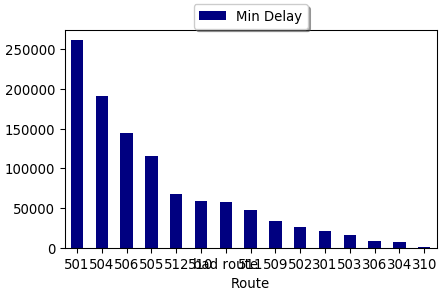

In [119]:
display(df)